# 使用预测数据进行电价预测

# 前期准备

导入所需库

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib
import chinese_calendar as cc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import pickle

设置字体

In [4]:
matplotlib.rcParams["font.sans-serif"] = ["Liberation Sans"]

# 数据预处理

读取并合并市场披露数据（包括对齐24个点和96个点的数据）

In [7]:
data_path = "../data/"
data_path_2024 = data_path + "2024/"
data_path_2025 = data_path + "2025/"

elec_price_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024电价数据_24点_cleaned.csv", sep="\t")
elec_out_price_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024东送计划_96点_cleaned.csv", sep="\t")
non_martket_elec_gen_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024非市场化出力_96点_cleaned.csv", sep="\t")
ele_load_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024负荷数据_96点_cleaned.csv", sep="\t")
new_energy_elec_gen_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024新能源出力数据_96点_cleaned.csv", sep="\t")

df_15_features = [elec_out_price_df_2024, non_martket_elec_gen_df_2024, ele_load_df_2024, new_energy_elec_gen_df_2024]

for i in range(len(df_15_features)):
    df = df_15_features[i]
    df = df.sort_values('datetime')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.resample('H', closed='right', label='right').mean()
    df_15_features[i] = df

elec_price_df_2024['datetime'] = pd.to_datetime(elec_price_df_2024['datetime'])
elec_price_df_2024.set_index('datetime', inplace=True)

merged_df = pd.concat([elec_price_df_2024] + df_15_features, axis=1)
print(merged_df.loc['2024-01-02'][0:3])
print(merged_df.columns)

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格     东送计划预测  \
datetime                                                                    
2024-01-02 00:00:00    328.09     264.64     381.57     372.27  2100.0000   
2024-01-02 01:00:00    364.71     347.72     378.77     274.10  2100.0000   
2024-01-02 02:00:00    386.24     384.98     387.28     221.28  2099.9975   

                        东送计划实测    非市场出力计划  非市场出力计划实测    统调负荷预测     统调负荷实测  \
datetime                                                                    
2024-01-02 00:00:00  2140.2275  6625.5225  6770.1775  41067.35  40525.650   
2024-01-02 01:00:00  2116.7025  6589.3075  6634.9475  39946.65  40046.850   
2024-01-02 02:00:00  2107.8150  6614.6975  6606.2650  39880.25  40029.675   

                       新能源出力预测     新能源出力实测     风电出力预测     风电出力实测  光伏出力预测  \
datetime                                                                   
2024-01-02 00:00:00  14503.555  14502.4325  14457.025  14525.800  46.530   


预处理天气数据

In [4]:
weather_data_2024_all = pd.read_csv(data_path_2024 + '内蒙2024天气.csv', sep=',')

''' 天气参数
id: 数据id
region_code: 行政区号
region_name: 行政区名
t2m: 2米温度
ws10m: 10米风速
ssrd: 向下表面太阳辐射（辐照）
tp: 总降水量(precipitation)
rh: 相对湿度
datetime: 时间戳
lng: 经度
lat: 纬度
'''
# 设置列名
weather_data_2024_all.columns = ['id', 'region_code', 'region_name', 't2m', 'ws10m', 'ssrd', 'tp', 'rh', 'datetime', 'lng', 'lat']
weather_data_2024 = weather_data_2024_all.drop(columns=['id', 'lng', 'lat', 'region_name'])
weather_data_2024['datetime'] = pd.to_datetime(weather_data_2024['datetime'], dayfirst=True)
weather_data_2024.set_index('datetime', inplace=True)
weather_data_2024_filtered = weather_data_2024[weather_data_2024['region_code'].isin([1501, 1502])]

weather_1501 = weather_data_2024_filtered[weather_data_2024_filtered['region_code'] == 1501].copy()
weather_1502 = weather_data_2024_filtered[weather_data_2024_filtered['region_code'] == 1502].copy()
weather_1501.drop(columns=['region_code'], inplace=True)
weather_1502.drop(columns=['region_code'], inplace=True)
weather_1501.rename(columns={
    't2m': 't2m_1501',
    'ws10m': 'ws10m_1501',
    'ssrd': 'ssrd_1501',
    'tp': 'tp_1501',
    'rh': 'rh_1501'
}, inplace=True)
weather_1502.rename(columns={
    't2m': 't2m_1502',
    'ws10m': 'ws10m_1502',
    'ssrd': 'ssrd_1502',
    'tp': 'tp_1502',
    'rh': 'rh_1502'
}, inplace=True)

weather_1501 = weather_1501[~weather_1501.index.duplicated(keep='first')]
weather_1502 = weather_1502[~weather_1502.index.duplicated(keep='first')]

merged_weather_2024 = pd.merge(weather_1501, weather_1502, left_index=True, right_index=True, how='outer')

print(merged_weather_2024.loc['2024-01-02'][0:3])

                     t2m_1501  ws10m_1501  ssrd_1501  tp_1501  rh_1501  \
datetime                                                                 
2024-01-02 00:00:00   -9.3586      0.8648        0.0      0.0   0.7457   
2024-01-02 01:00:00  -10.2181      0.7868        0.0      0.0   0.7487   
2024-01-02 02:00:00  -10.1093      0.8430        0.0      0.0   0.7481   

                     t2m_1502  ws10m_1502  ssrd_1502  tp_1502  rh_1502  
datetime                                                                
2024-01-02 00:00:00  -12.7961      2.0977        0.0      0.0   0.7343  
2024-01-02 01:00:00  -14.1596      2.5779        0.0      0.0   0.7424  
2024-01-02 02:00:00  -14.6581      2.8571        0.0      0.0   0.7470  


合并数据+丢弃实测数据

In [5]:
merged_df_with_weather = merged_df.merge(merged_weather_2024, left_index=True, right_index=True, how='outer')
merged_df_with_weather['price_bidding_space'] = merged_df_with_weather['统调负荷预测'] + merged_df_with_weather['东送计划预测'] - merged_df_with_weather['新能源出力预测'] - merged_df_with_weather['非市场出力计划']
merged_df_filtered = merged_df_with_weather.drop(columns=['东送计划实测', '统调负荷实测', '新能源出力实测', '风电出力实测', '光伏出力实测', '非市场出力计划实测'])

print(merged_df_filtered.loc['2024-01-02'][0:3])

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格     东送计划预测  \
datetime                                                                    
2024-01-02 00:00:00    328.09     264.64     381.57     372.27  2100.0000   
2024-01-02 01:00:00    364.71     347.72     378.77     274.10  2100.0000   
2024-01-02 02:00:00    386.24     384.98     387.28     221.28  2099.9975   

                       非市场出力计划    统调负荷预测    新能源出力预测     风电出力预测  光伏出力预测  ...  \
datetime                                                                ...   
2024-01-02 00:00:00  6625.5225  41067.35  14503.555  14457.025  46.530  ...   
2024-01-02 01:00:00  6589.3075  39946.65  15205.300  15141.550  63.750  ...   
2024-01-02 02:00:00  6614.6975  39880.25  15584.530  15513.425  71.105  ...   

                     ws10m_1501  ssrd_1501  tp_1501  rh_1501  t2m_1502  \
datetime                                                                 
2024-01-02 00:00:00      0.8648        0.0      0.0   0.7457  -12.7961

去除NA数据

In [6]:
merged_df_filtered = merged_df_filtered.dropna()

print(merged_df_filtered.head())

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格     东送计划预测  \
datetime                                                                    
2024-01-01 09:00:00    430.32     426.92     433.48     457.50  3805.5000   
2024-01-01 10:00:00    409.45     407.92     410.91     422.50  4200.0000   
2024-01-01 11:00:00    384.81     397.11     373.26     387.50  4200.0000   
2024-01-01 12:00:00    348.15     354.58     342.46     220.25  3544.4975   
2024-01-01 13:00:00      8.24       0.00      15.26       0.14  3150.0000   

                       非市场出力计划     统调负荷预测     新能源出力预测     风电出力预测     光伏出力预测  \
datetime                                                                      
2024-01-01 09:00:00  6530.1175  41794.525  13527.8425  12813.325   714.5175   
2024-01-01 10:00:00  6539.4125  41782.450  15678.7600  12559.650  3119.1100   
2024-01-01 11:00:00  6603.2050  41728.425  17931.3600  12092.225  5839.1350   
2024-01-01 12:00:00  6567.9600  41542.250  19255.7275  11652.375 

In [7]:
print(merged_df_filtered.columns)

Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '日前预出清电能价格', '东送计划预测', '非市场出力计划',
       '统调负荷预测', '新能源出力预测', '风电出力预测', '光伏出力预测', 't2m_1501', 'ws10m_1501',
       'ssrd_1501', 'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502',
       'ssrd_1502', 'tp_1502', 'rh_1502', 'price_bidding_space'],
      dtype='object')


In [8]:
tmp_df = merged_df_filtered.copy()

tmp_df.drop(
    columns=
    ['t2m_1501', 'ssrd_1501', 'tp_1501', 'rh_1501', 
     't2m_1502', 'ssrd_1502', 'tp_1502', 'rh_1502'],
     inplace=True
     )

merged_df_filtered = tmp_df.copy()

print(merged_df_filtered.columns)

Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '日前预出清电能价格', '东送计划预测', '非市场出力计划',
       '统调负荷预测', '新能源出力预测', '风电出力预测', '光伏出力预测', 'ws10m_1501', 'ws10m_1502',
       'price_bidding_space'],
      dtype='object')


检查并处理缺失数据

In [9]:
def deal_missing_data(df_data):
    complete_time_range = pd.date_range(
        start=df_data.index.min(),
        end=df_data.index.max(),
        freq='h'
    )
    initial_missing = complete_time_range.difference(df_data.index)
    print(f"Initial missing timestamps: {len(initial_missing)}")
    if len(initial_missing) == 0:
        print("No need to deal missing data.")
        return df_data

    print("Dealing with missing data.")
    print("Initial missing dates:", pd.Series(initial_missing.date).value_counts())

    df_reindexed = df_data.reindex(complete_time_range)
    df_reindexed['date'] = df_reindexed.index.date
    missing_flag = df_reindexed.drop(columns='date').isna().any(axis=1)
    missing_count_per_day = missing_flag.groupby(df_reindexed['date']).sum()
    print("Missing timestamps per day:")
    print(missing_count_per_day)

    threshold = 8
    days_to_drop = missing_count_per_day[missing_count_per_day > threshold].index
    print(f"\nDays to drop: {len(days_to_drop)}")

    df_cleaned = df_reindexed[~df_reindexed['date'].isin(days_to_drop)].copy()
    df_cleaned.drop(columns='date', inplace=True)
    
    df_filled = df_cleaned.interpolate(method='time')

    expected_range = pd.date_range(
        start=df_filled.index.min(),
        end=df_filled.index.max(),
        freq='h'
    )
    missing_timestamps = expected_range.difference(df_filled.index)
    print(f"Total missing timestamps: {len(missing_timestamps)}")
    print("\nMissing timestamps by date:")
    missing_dates = pd.Series(missing_timestamps.date).value_counts().sort_index()
    print(missing_dates)
    
    return df_filled

df_cleaned = deal_missing_data(merged_df_filtered)

Initial missing timestamps: 48
Dealing with missing data.
Initial missing dates: 2024-01-21    23
2024-07-21    23
2024-01-22     1
2024-07-22     1
Name: count, dtype: int64
Missing timestamps per day:
date
2024-01-01    0
2024-01-02    0
2024-01-03    0
2024-01-04    0
2024-01-05    0
             ..
2024-12-28    0
2024-12-29    0
2024-12-30    0
2024-12-31    0
2025-01-01    0
Length: 367, dtype: int64

Days to drop: 2
Total missing timestamps: 48

Missing timestamps by date:
2024-01-21    24
2024-07-21    24
Name: count, dtype: int64


归一化之前导出到csv保存

In [10]:
df_cleaned.rename(columns={
    '全网统一出清电价': 'unified_price', 
    '呼包东统一出清电价': 'east_price',
    '呼包西统一出清电价': 'west_price',
    '东送计划预测': 'east_trans_load', 
    '非市场出力计划': 'non_market_output_load',
    '统调负荷预测': 'unified_dispatch_load',
    '新能源出力预测': 'new_energy_output_load',
    '风电出力预测': 'wind_power_output_load',
    '光伏出力预测': 'solar_power_output_load',
    '日前预出清电能价格': 'preday_price_prediction'
}, inplace=True)
print(df_cleaned.columns)
df_cleaned.to_csv("../output/df_cleaned.csv", index=True, encoding="utf-8-sig")

Index(['unified_price', 'east_price', 'west_price', 'preday_price_prediction',
       'east_trans_load', 'non_market_output_load', 'unified_dispatch_load',
       'new_energy_output_load', 'wind_power_output_load',
       'solar_power_output_load', 'ws10m_1501', 'ws10m_1502',
       'price_bidding_space'],
      dtype='object')


归一化

In [11]:
print("Before normalized:")
print(df_cleaned.head(1))

columns_to_scale = [col for col in df_cleaned.columns if col not in ['weekday_num', 'is_workday', 'is_holiday', 'season']]
normalized_df = df_cleaned.copy()

scalers = {}

for col in columns_to_scale:
    if 'price' in col:
        scaler = RobustScaler()
    elif 'load' in col:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()

    normalized_df[col] = scaler.fit_transform(normalized_df[[col]])
    scalers[col] = scaler

with open('../scaler_model/scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

print("After normalized:")
print(normalized_df.head(1))

normalized_df.to_csv("../output/normalized_df.csv", index=True, encoding="utf-8-sig")

Before normalized:
                     unified_price  east_price  west_price  \
2024-01-01 09:00:00         430.32      426.92      433.48   

                     preday_price_prediction  east_trans_load  \
2024-01-01 09:00:00                    457.5           3805.5   

                     non_market_output_load  unified_dispatch_load  \
2024-01-01 09:00:00               6530.1175              41794.525   

                     new_energy_output_load  wind_power_output_load  \
2024-01-01 09:00:00              13527.8425               12813.325   

                     solar_power_output_load  ws10m_1501  ws10m_1502  \
2024-01-01 09:00:00                 714.5175      0.7768      1.1007   

                     price_bidding_space  
2024-01-01 09:00:00            25542.065  
After normalized:
                     unified_price  east_price  west_price  \
2024-01-01 09:00:00       0.069545    0.053859    0.068997   

                     preday_price_prediction  east_trans_load  \
20

# 训练模型

环境设置

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

搭建模型

In [13]:
def create_sliding_windows(data, input_length, output_length, target_indices):
    """
    构造滑动窗口数据
    :param data: numpy 数组，形状 (T, num_features)
    :param input_length: 输入序列长度（例如24个点代表1天）
    :param output_length: 输出序列长度（预测下一天的24个点）
    :param target_indices: 目标特征在数据中的索引列表
    :return: X, Y，分别为输入和目标序列
    """
    # 参数验证
    if not isinstance(data, np.ndarray):
        data = np.array(data, dtype=np.float32)
    
    if len(data.shape) != 2:
        raise ValueError(f"数据维度必须为2，当前维度为 {len(data.shape)}")
        
    total_length, num_features = data.shape
    min_length = input_length + output_length
    print(f'total_length: {total_length}, num_features: {num_features}, min_length: {min_length}')
    
    if total_length < min_length:
        raise ValueError(f"数据长度({total_length})小于所需最小长度({min_length})")
        
    if max(target_indices) >= num_features:
        raise ValueError(f"目标特征索引超出范围: {target_indices}, 特征数量: {num_features}")

    try:
        # 预分配内存
        samples_count = total_length - input_length - output_length + 1
        X = np.zeros((samples_count, input_length, num_features), dtype=np.float32)
        Y = np.zeros((samples_count, output_length, len(target_indices)), dtype=np.float32)
        
        # 构建滑动窗口
        for i in range(samples_count):
            X[i] = data[i:i + input_length]
            Y[i] = data[i + input_length:i + input_length + output_length][:, target_indices]
            
        return X, Y
        
    except Exception as e:
        print(f"创建滑动窗口时发生错误: {str(e)}")
        raise

# 检查输入数据
if not isinstance(normalized_df, (np.ndarray, pd.DataFrame)):
    raise TypeError("normalized_df 必须是 numpy 数组或 pandas DataFrame")

# 数据预处理
data_array = normalized_df.astype(np.float32)
target_columns = ['east_price', 'west_price']

# 获取目标特征的索引
features = normalized_df.columns.tolist()
target_indices = [features.index(col) for col in target_columns]

# 参数设置
input_length = 48    # 输入序列长度
output_length = 24   # 输出序列长度
# 构造滑动窗口数据
X, Y = create_sliding_windows(data_array, input_length, output_length, target_indices)
print(f"\n数据集信息:")
print(f"样本总数: {X.shape[0]}")
print(f"输入形状: {X.shape[1:]} (时间步, 特征数)")
print(f"输出形状: {Y.shape[1:]} (预测步数, 目标特征数)")

# 构造 PyTorch Dataset 和 DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        """
        :param X: numpy 数组，形状 (num_samples, input_length, num_features)
        :param Y: numpy 数组，形状 (num_samples, output_length, num_target_features)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 划分训练集和验证集
split_idx = int(0.8 * len(X))
X_train, Y_train = X[:split_idx], Y[:split_idx]
X_val, Y_val = X[split_idx:], Y[split_idx:]

train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset = TimeSeriesDataset(X_val, Y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 构建 DLinear 模型
class DLinear(nn.Module):
    def __init__(self, input_length, output_length, num_features, target_feature_num, target_indices):
        """
        :param input_length: 输入序列的时间步数
        :param output_length: 输出序列的时间步数
        :param num_features: 输入特征数量
        :param target_feature_num: 目标特征数量（目前是2个区域的电价）
        :param target_indices: 目标特征在所有特征中的索引列表
        """
        super(DLinear, self).__init__()
        # 为每个输入特征创建一个独立的线性层
        self.linear_layers = nn.ModuleList([
            nn.Linear(input_length, output_length) for _ in range(num_features)
        ])
        self.num_features = num_features
        self.target_feature_num = target_feature_num
        self.target_indices = target_indices
        
    def forward(self, x):
        """
        :param x: 输入张量，形状 (batch_size, input_length, num_features)
        :return: 预测结果，形状 (batch_size, output_length, target_feature_num)
        """
        out_list = []
        # 对每个特征独立进行预测
        for i, layer in enumerate(self.linear_layers):
            # 取出第 i 个特征，形状：(batch_size, input_length)
            xi = x[:, :, i]
            # 线性预测得到：(batch_size, output_length)
            yi = layer(xi)
            out_list.append(yi.unsqueeze(-1))  # 变为 (batch_size, output_length, 1)
        # 拼接所有特征的预测结果，形状：(batch_size, output_length, num_features)
        out = torch.cat(out_list, dim=-1)
        prediction = out[:, :, self.target_indices]
        return prediction

# 模型参数
num_features = len(features)           # 输入所有特征的数量
target_feature_num = len(target_columns) # 预测目标的数量（2个区域）

model = DLinear(input_length=input_length, 
                output_length=output_length, 
                num_features=num_features, 
                target_feature_num=target_feature_num,
                target_indices=target_indices)

print("\nDLinear 模型结构：")
print(model)

total_length: 8728, num_features: 13, min_length: 72

数据集信息:
样本总数: 8657
输入形状: (48, 13) (时间步, 特征数)
输出形状: (24, 2) (预测步数, 目标特征数)

DLinear 模型结构：
DLinear(
  (linear_layers): ModuleList(
    (0-12): 13 x Linear(in_features=48, out_features=24, bias=True)
  )
)


训练模型

Epoch 1/100 - Train Loss: 1.922256 - Val Loss: 0.982125
Epoch 2/100 - Train Loss: 1.399163 - Val Loss: 0.873000
Epoch 3/100 - Train Loss: 1.263591 - Val Loss: 0.832024
Epoch 4/100 - Train Loss: 1.201683 - Val Loss: 0.809607
Epoch 5/100 - Train Loss: 1.168657 - Val Loss: 0.796684
Epoch 6/100 - Train Loss: 1.148946 - Val Loss: 0.788044
Epoch 7/100 - Train Loss: 1.136387 - Val Loss: 0.781814
Epoch 8/100 - Train Loss: 1.127471 - Val Loss: 0.771061
Epoch 9/100 - Train Loss: 1.120168 - Val Loss: 0.767702
Epoch 10/100 - Train Loss: 1.113567 - Val Loss: 0.764441
Epoch 11/100 - Train Loss: 1.108767 - Val Loss: 0.766602
Epoch 12/100 - Train Loss: 1.105596 - Val Loss: 0.757979
Epoch 13/100 - Train Loss: 1.100687 - Val Loss: 0.754491
Epoch 14/100 - Train Loss: 1.097084 - Val Loss: 0.761859
Epoch 15/100 - Train Loss: 1.095268 - Val Loss: 0.760133
Epoch 16/100 - Train Loss: 1.093544 - Val Loss: 0.755585
Epoch 17/100 - Train Loss: 1.089968 - Val Loss: 0.751832
Epoch 18/100 - Train Loss: 1.089451 - Va

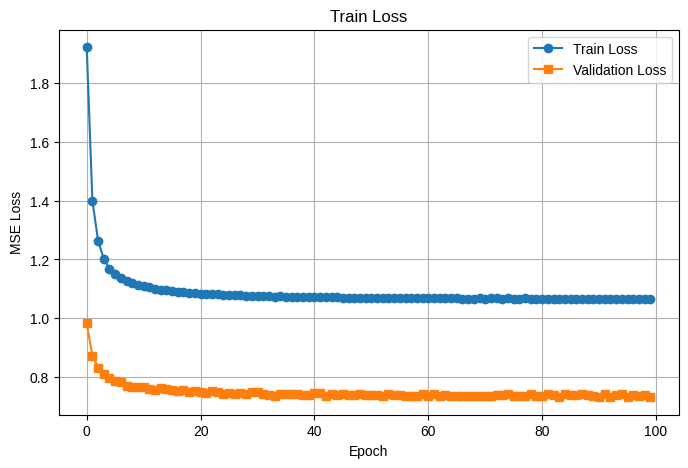

In [14]:
model.to(device)

# 定义损失函数（均方误差）和优化器（Adam）
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 100  # 根据实际情况调整

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)
        optimizer.zero_grad()
        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        # 反向传播与优化
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * batch_X.size(0)
    
    epoch_train_loss /= len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # 验证阶段
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            epoch_val_loss += loss.item() * batch_X.size(0)
    epoch_val_loss /= len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.6f} - Val Loss: {epoch_val_loss:.6f}")

# 可视化训练过程
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train Loss')
plt.legend()
plt.grid(True)
plt.show()

# 预测新数据

读取2025年新数据

In [15]:
elec_price_df_2025 = pd.read_csv(data_path_2025 + "202501电价数据_24点_cleaned.csv", sep="\t")
elec_out_price_df_2025 = pd.read_csv(data_path_2025 + "202501东送计划_96点_cleaned.csv", sep="\t")
non_martket_elec_gen_df_2025 = pd.read_csv(data_path_2025 + "202501非市场化出力_96点_cleaned.csv", sep="\t")
ele_load_df_2025 = pd.read_csv(data_path_2025 + "202501负荷数据_96点_cleaned.csv", sep="\t")
new_energy_elec_gen_df_2025 = pd.read_csv(data_path_2025 + "202501新能源处理_96点_cleaned.csv", sep="\t")

df_15_2025 = [elec_out_price_df_2025, non_martket_elec_gen_df_2025, ele_load_df_2025, new_energy_elec_gen_df_2025]

for i in range(len(df_15_2025)):
    df = df_15_2025[i]
    df = df.sort_values('datetime')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.resample('H', closed='right', label='right').sum()
    df_15_2025[i] = df

elec_price_df_2025['datetime'] = pd.to_datetime(elec_price_df_2025['datetime'])
elec_price_df_2025.set_index('datetime', inplace=True)

merged_df_2025 = pd.concat([elec_price_df_2025] + df_15_2025, axis=1)

数据预处理

In [16]:
# 天气
weather_data_2025_all = pd.read_csv(data_path_2025 + '内蒙2025天气.csv', sep=',')

''' 天气参数
id: 数据id
region_code: 行政区号
region_name: 行政区名
t2m: 2米温度
ws10m: 10米风速
ssrd: 向下表面太阳辐射（辐照）
tp: 总降水量(precipitation)
rh: 相对湿度
datetime: 时间戳
lng: 经度
lat: 纬度
'''
# 设置列名
weather_data_2025_all.columns = ['id', 'region_code', 'region_name', 't2m', 'ws10m', 'ssrd', 'tp', 'rh', 'datetime', 'lng', 'lat']
weather_data_2025 = weather_data_2025_all.drop(columns=['id', 'lng', 'lat', 'region_name'])
weather_data_2025['datetime'] = pd.to_datetime(weather_data_2025['datetime'], dayfirst=True)
weather_data_2025.set_index('datetime', inplace=True)
weather_data_2025_filtered = weather_data_2025[weather_data_2025['region_code'].isin([1501, 1502])]

weather_1501 = weather_data_2025_filtered[weather_data_2025_filtered['region_code'] == 1501].copy()
weather_1502 = weather_data_2025_filtered[weather_data_2025_filtered['region_code'] == 1502].copy()
weather_1501.drop(columns=['region_code'], inplace=True)
weather_1502.drop(columns=['region_code'], inplace=True)
weather_1501.rename(columns={
    't2m': 't2m_1501',
    'ws10m': 'ws10m_1501',
    'ssrd': 'ssrd_1501',
    'tp': 'tp_1501',
    'rh': 'rh_1501'
}, inplace=True)
weather_1502.rename(columns={
    't2m': 't2m_1502',
    'ws10m': 'ws10m_1502',
    'ssrd': 'ssrd_1502',
    'tp': 'tp_1502',
    'rh': 'rh_1502'
}, inplace=True)

weather_1501 = weather_1501[~weather_1501.index.duplicated(keep='first')]
weather_1502 = weather_1502[~weather_1502.index.duplicated(keep='first')]

merged_weather_2025 = pd.merge(weather_1501, weather_1502, left_index=True, right_index=True, how='outer')

# 合并数据+丢弃预测数据
merged_df_with_weather = merged_df_2025.merge(merged_weather_2025, left_index=True, right_index=True, how='outer')
merged_df_with_weather['price_bidding_space'] = merged_df_with_weather['统调负荷预测'] + merged_df_with_weather['东送计划预测'] - merged_df_with_weather['新能源出力预测'] - merged_df_with_weather['非市场出力计划']
merged_df_filtered_2025 = merged_df_with_weather.drop(columns=['东送计划实测', '统调负荷实测', '新能源出力实测', '风电出力实测', '光伏出力实测', '非市场出力计划实测'])

merged_df_filtered_2025 = merged_df_filtered_2025.dropna()

print(merged_df_filtered_2025.columns)

# 检查并处理缺失数据
df_cleaned_2025 = deal_missing_data(merged_df_filtered_2025)

Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '日前预出清电能价格', '东送计划预测', '非市场出力计划',
       '统调负荷预测', '新能源出力预测', '风电出力预测', '光伏出力预测', 't2m_1501', 'ws10m_1501',
       'ssrd_1501', 'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502',
       'ssrd_1502', 'tp_1502', 'rh_1502', 'price_bidding_space'],
      dtype='object')
Initial missing timestamps: 0
No need to deal missing data.


In [17]:
tmp_df = df_cleaned_2025.copy()

tmp_df.drop(
    columns=
    ['t2m_1501', 'ssrd_1501', 'tp_1501', 'rh_1501', 
     't2m_1502', 'ssrd_1502', 'tp_1502', 'rh_1502'],
     inplace=True
     )

df_cleaned_2025 = tmp_df.copy()

print(df_cleaned_2025.columns)
print(df_cleaned_2025.head(1))
print(df_cleaned_2025.tail(1))

Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '日前预出清电能价格', '东送计划预测', '非市场出力计划',
       '统调负荷预测', '新能源出力预测', '风电出力预测', '光伏出力预测', 'ws10m_1501', 'ws10m_1502',
       'price_bidding_space'],
      dtype='object')
                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格  东送计划预测  \
datetime                                                                 
2025-01-01 01:00:00   661.271    779.739    573.111      385.0  8400.0   

                      非市场出力计划    统调负荷预测   新能源出力预测    风电出力预测  光伏出力预测  \
datetime                                                              
2025-01-01 01:00:00  26635.98  171668.4  31889.43  31776.84  112.59   

                     ws10m_1501  ws10m_1502  price_bidding_space  
datetime                                                          
2025-01-01 01:00:00      1.5147      2.1344            121542.99  
            全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格  东送计划预测   非市场出力计划  \
datetime                                                                  
2025

In [18]:
# 重命名列名
df_cleaned_2025.rename(columns={
    '全网统一出清电价': 'unified_price', 
    '呼包东统一出清电价': 'east_price',
    '呼包西统一出清电价': 'west_price',
    '东送计划预测': 'east_trans_load', 
    '非市场出力计划': 'non_market_output_load',
    '统调负荷预测': 'unified_dispatch_load',
    '新能源出力预测': 'new_energy_output_load',
    '风电出力预测': 'wind_power_output_load',
    '光伏出力预测': 'solar_power_output_load',
    '日前预出清电能价格': 'preday_price_prediction'
}, inplace=True)

print(df_cleaned_2025.columns)

# 使用已有的标准化器进行数据标准化
normalized_data_2025 = df_cleaned_2025.copy()
for col in columns_to_scale:
    scaler = scalers[col]
    normalized_data_2025[col] = scaler.transform(df_cleaned_2025[[col]])

# 使用已有的 create_sliding_windows 函数创建测试数据
X_test, Y_test = create_sliding_windows(normalized_data_2025, input_length, output_length, target_indices)

Index(['unified_price', 'east_price', 'west_price', 'preday_price_prediction',
       'east_trans_load', 'non_market_output_load', 'unified_dispatch_load',
       'new_energy_output_load', 'wind_power_output_load',
       'solar_power_output_load', 'ws10m_1501', 'ws10m_1502',
       'price_bidding_space'],
      dtype='object')
total_length: 744, num_features: 13, min_length: 72


预测

In [19]:
model.to(device)
model.eval()  # set model to evaluation mode
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_pred = model(X_test_tensor)  # predictions in normalized scale
    Y_pred = Y_pred.cpu().numpy()  # convert predictions to numpy array for post-processing

In [37]:
def verify_prediction_alignment(Y_pred, Y_test, df_original, start_idx=0, n_samples=5):
    """
    验证预测值与实际值的时间对齐情况
    
    Args:
        Y_pred: 模型预测结果
        Y_test: 测试集真实值
        df_original: 原始CSV数据
        start_idx: 起始索引
        n_samples: 要显示的样本数
    """
    print("\n=== 预测对齐验证 ===")
    print("时间点\t\t预测值\t实际值\tCSV实际值")
    print("-" * 60)
    
    # 获取对应的时间戳
    base_time = pd.Timestamp('2025-01-01') + pd.Timedelta(hours=start_idx+2*24)
    
    for i in range(n_samples):
        current_time = base_time + pd.Timedelta(hours=i)
        csv_value = df_original.loc[current_time, 'east_price']
        pred_value = Y_pred[0, i, 0]  # 第一个预测窗口的结果
        test_value = Y_test[0, i, 0]  # 第一个测试窗口的实际值
        
        print(f"{current_time}: {pred_value:.2f}\t{test_value:.2f}\t{csv_value:.2f}")

verify_prediction_alignment(
    Y_pred=Y_pred,  # 原始预测结果
    Y_test=Y_test,  # 原始测试集
    df_original=df_cleaned_2025,  # 原始数据
    start_idx=0
)


=== 预测对齐验证 ===
时间点		预测值	实际值	CSV实际值
------------------------------------------------------------
2025-01-03 00:00:00: -0.09	-0.18	357.48
2025-01-03 01:00:00: -0.09	-0.30	358.35
2025-01-03 02:00:00: -0.09	-0.21	322.36
2025-01-03 03:00:00: -0.11	-0.28	349.64
2025-01-03 04:00:00: -0.16	-0.26	327.90


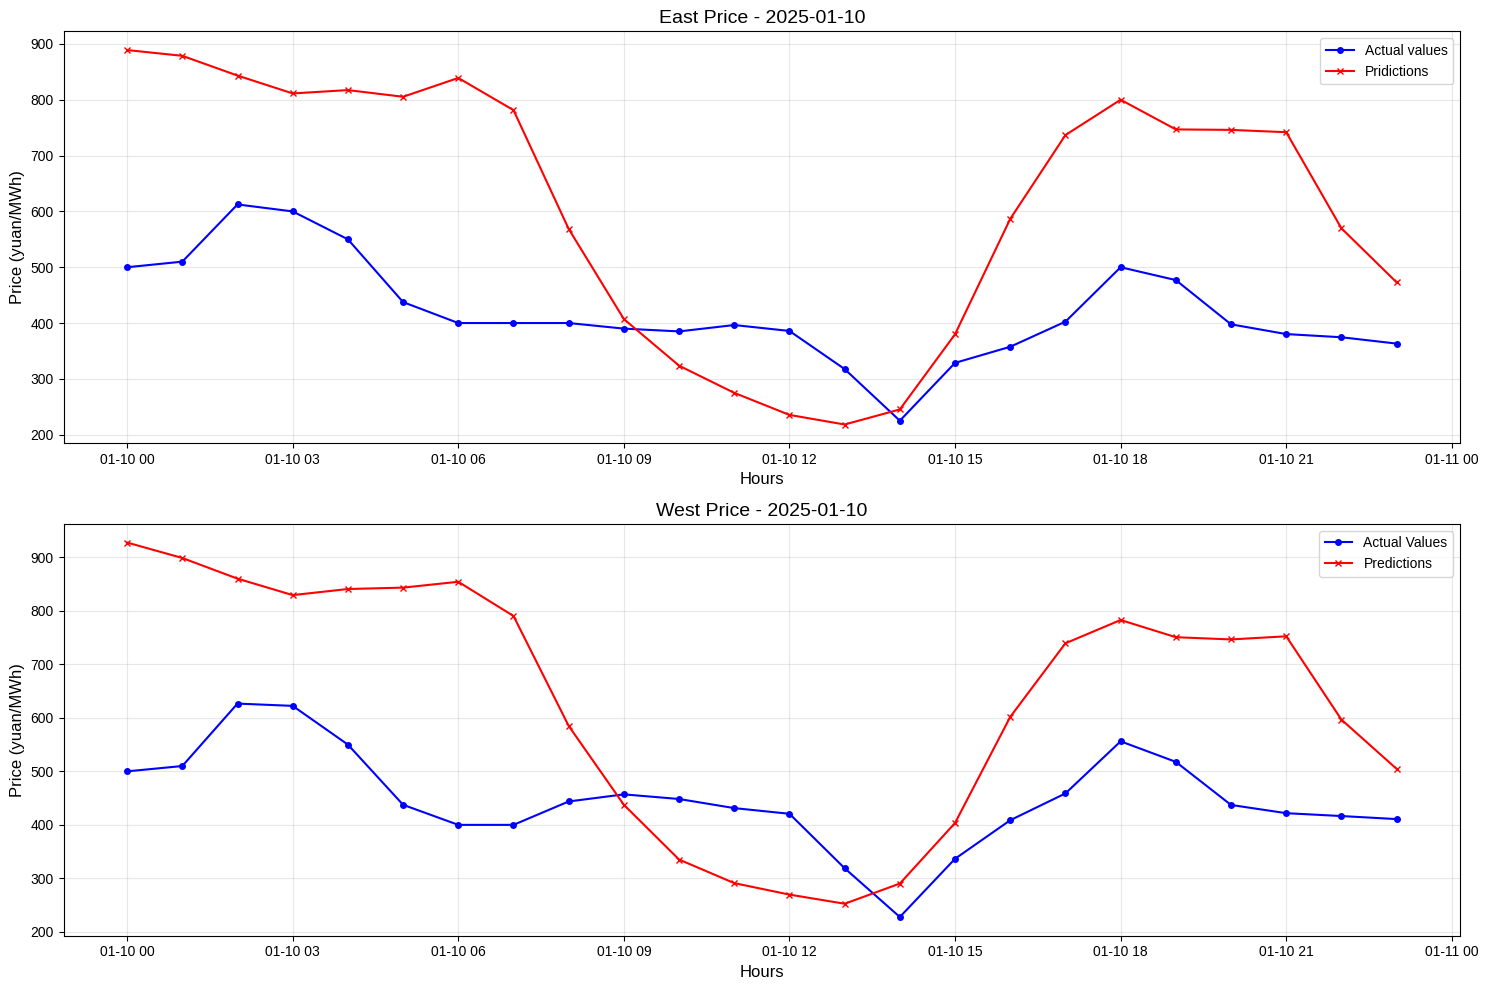


评估指标 (原始单位：元/MWh):
东区 - MSE: 73761.64, MAE: 184.74
西区 - MSE: 68959.68, MAE: 179.69

相对误差:
东区 - MAPE: 215025301.04%
西区 - MAPE: 12240966.39%


In [44]:
def process_overlapping_predictions(Y_pred, Y_test, output_length, scalers, target_columns):
    n_samples = Y_pred.shape[0]
    n_features = Y_pred.shape[2]
    
    # 创建累加器和计数器
    total_length = n_samples + output_length - 1
    predictions_sum = np.zeros((total_length, n_features))
    predictions_count = np.zeros((total_length, n_features))
    true_values = np.zeros((total_length, n_features))
    
    for i in range(n_samples):
        for j in range(output_length):
            pred_idx = i + j
            true_idx = i + j + 1  # 真实值向后偏移一步
            
            if pred_idx < total_length:
                predictions_sum[pred_idx] += Y_pred[i, j]
                predictions_count[pred_idx] += 1
            if true_idx < total_length:
                true_values[true_idx] = Y_test[i, j]
    
    # 计算平均值并进行反标准化
    averaged_predictions = np.where(predictions_count > 0, 
                                  predictions_sum / predictions_count, 
                                  0)
    
    # 反标准化过程保持不变
    averaged_predictions_orig = np.zeros_like(averaged_predictions)
    true_values_orig = np.zeros_like(true_values)
    
    for i, col in enumerate(target_columns):
        scaler = scalers[col]
        averaged_predictions_orig[:, i] = scaler.inverse_transform(
            averaged_predictions[:, i].reshape(-1, 1)).ravel()
        true_values_orig[:, i] = scaler.inverse_transform(
            true_values[:, i].reshape(-1, 1)).ravel()
    
    return averaged_predictions_orig, true_values_orig

# 处理重叠预测并反标准化
averaged_predictions_orig, true_values_orig = process_overlapping_predictions(
    Y_pred=Y_pred, 
    Y_test=Y_test, 
    output_length=output_length,
    scalers=scalers,
    target_columns=['east_price', 'west_price']
)

# 绘制平均后的预测结果
def plot_averaged_predictions(true_values, averaged_predictions, start_idx=0, window_size=24):
    plt.figure(figsize=(15, 10))
    start_time = pd.Timestamp('2025-01-01') + pd.Timedelta(hours=start_idx+2*24)
    time_steps = pd.date_range(start=start_time, periods=window_size, freq='H')
    
    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_values[start_idx:start_idx+window_size, 0], 
             label='Actual values', marker='o', markersize=4, color='blue')
    plt.plot(time_steps, averaged_predictions[start_idx:start_idx+window_size, 0], 
             label='Pridictions', marker='x', markersize=4, color='red')
    plt.title(f'East Price - {start_time.strftime("%Y-%m-%d")}', fontsize=14)
    plt.xlabel('Hours', fontsize=12)
    plt.ylabel('Price (yuan/MWh)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 西区电价对比图
    plt.subplot(2, 1, 2)
    plt.plot(time_steps, true_values[start_idx:start_idx+window_size, 1], 
             label='Actual Values', marker='o', markersize=4, color='blue')
    plt.plot(time_steps, averaged_predictions[start_idx:start_idx+window_size, 1], 
             label='Predictions', marker='x', markersize=4, color='red')
    plt.title(f'West Price - {start_time.strftime("%Y-%m-%d")}', fontsize=14)
    plt.xlabel('Hours', fontsize=12)
    plt.ylabel('Price (yuan/MWh)', fontsize=12)  # 添加单位
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制平均后的预测结果
plot_averaged_predictions(true_values_orig, averaged_predictions_orig, start_idx=24*7)

# 计算平均后的评估指标
mse_avg = np.mean((true_values_orig - averaged_predictions_orig) ** 2, axis=0)
mae_avg = np.mean(np.abs(true_values_orig - averaged_predictions_orig), axis=0)
print(f"\n评估指标 (原始单位：元/MWh):")
print(f"东区 - MSE: {mse_avg[0]:.2f}, MAE: {mae_avg[0]:.2f}")
print(f"西区 - MSE: {mse_avg[1]:.2f}, MAE: {mae_avg[1]:.2f}")

# 计算相对误差
mape_avg = np.mean(np.abs((true_values_orig - averaged_predictions_orig) / true_values_orig), axis=0) * 100
print(f"\n相对误差:")
print(f"东区 - MAPE: {mape_avg[0]:.2f}%")
print(f"西区 - MAPE: {mape_avg[1]:.2f}%")